In [1]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image

plt.style.use("fivethirtyeight")
# sns.set_palette("muted")
%matplotlib inline

### Defining season

In [2]:
northern_hemisphere_seasons = {1: 'winter', 2: 'winter', 3: 'winter', 4: 'spring', 5: 'spring', 6: 'spring', 7: 'summer', 8: 'summer', 9: 'summer', 10: 'fall', 11: 'fall', 12: 'fall'}
southern_seasons = {7: 'winter', 8: 'winter', 9: 'winter', 10: 'spring', 11: 'spring', 12: 'spring', 1: 'summer', 2: 'summer', 3: 'summer', 4: 'fall', 5: 'fall', 6: 'fall'}

def get_season (date, seasons_dictionary = None):
    season = seasons_dictionary[date.month]
    return season

### Finding the coffee production schedule

In [3]:
pd.read_csv("../datasets/capstone/coffee harvest schedule.csv", index_col = 0).head(8)

,Producing Country,Coffee Type,Harvest Begins,Harvest Ends,Year-round Harvest
0,Angola,Arabica,April,June,False
1,Angola,Robusta,May,September,False
2,Benin,Robusta,November,February,False
3,Bolivia,Arabica,April,August,False
4,Borneo,Arabica,June,December,False
5,Borneo,Robusta,May,December,False
6,Brazil,Arabica,April,September,False
7,Brazil,Robusta,April,September,False


### Selecting weather stations by growing conditions

Selection criteria:
* Elevation in meters. Look between 548 m - 1100 m (1800-3600 feet) for latitudes between 16 and 24 degrees, or 1097 m - 1920 m (3600 feet to 6300 feet).
* Robusta grows best in elevations 0 m - 914 m (sea level-3000 feet) in latitudes between ±10°. 
* The ICA quota system collapsed in 1989. Look for data that exists between 1990 and 2017.

In [4]:
raw_station_ids = pd.read_csv("../datasets/capstone/NOAA-station-ids-isd-history.txt", header = 17)

In [5]:
station_ids = raw_station_ids.copy()
station_ids_column_names = station_ids.columns[0].split()
station_ids = station_ids.iloc[:, 0].str.split(expand = True)

In [6]:
brazilian_station_ids = station_ids[station_ids[3] == "BR"].dropna(axis = 1)
brazilian_station_ids.columns = ["USAF", "WBAN", "City", "Country", "Latitude", "Longitude", "Elevation", "Begin", "End"]
brazilian_station_ids.drop(21926, inplace = True) # Error in formatting
brazilian_station_ids.reset_index(drop = True, inplace = True)
brazilian_station_ids.loc[:, ["Latitude", "Longitude", "Elevation"]] = brazilian_station_ids[["Latitude", "Longitude", "Elevation"]].apply(pd.to_numeric, errors = 'coerce')
brazilian_station_ids.dropna(inplace = True)

In [7]:
# Elevation in meters. Look between 548 m - 1100 m (1800-3600 feet) for latitudes between 16 and 24 degrees, or 1097 m - 1920 m (3600 feet to 6300 feet)
arabica_growing_conditions_criteria = (brazilian_station_ids["Elevation"] >= 548) & (brazilian_station_ids["Elevation"] <= 1100) & (brazilian_station_ids["Latitude"].abs() > 16) & (brazilian_station_ids["Latitude"].abs() <= 24)
arabica_growing_conditions_criteria = arabica_growing_conditions_criteria | ((brazilian_station_ids["Elevation"] >= 1097) & (brazilian_station_ids["Elevation"] <= 1920) & (brazilian_station_ids["Latitude"].abs() <= 10))

# Robusta grows best in elevations 0 m - 914 m (sea level-3000 feet) in latitudes between ±10° 
robusta_growing_conditions_criteria = (brazilian_station_ids["Elevation"] <= 914) & (brazilian_station_ids["Latitude"].abs() <= 10)

# Look for data that exists between 1990 and 2017
time_availability_criteria = (brazilian_station_ids["Begin"].astype(int) < 19900000) & (brazilian_station_ids["End"].astype(int) > 20160000)

# Applying criteria
brazilian_station_ids = brazilian_station_ids[arabica_growing_conditions_criteria & time_availability_criteria]

### Downloading weather data from NCDC at NOAA

In [8]:
# Import NOAA data for Brazil
raw_brazil_weather_data = pd.read_csv("../datasets/capstone/Production Arabica Brazil 1989 - 2013 -- CDO537887251283.txt")

In [9]:
brazil_weather_data = raw_brazil_weather_data.copy()

# Removing whitespace from columns names
clean_brazil_weather_data_column_names = []
for column in brazil_weather_data.columns:
    clean_brazil_weather_data_column_names.append(column.strip())
brazil_weather_data.columns = clean_brazil_weather_data_column_names

# Dropping unnecessary columns
brazil_weather_data.drop(labels = ["Unnamed: 22"], axis = 1, inplace = True)
brazil_weather_data.drop(labels = ["GUST", "SNDP"], axis = 1, inplace = True)

# Converting time column and extracting month, year
brazil_weather_data["YEARMODA"] = brazil_weather_data["YEARMODA"].apply(pd.to_datetime, format = "%Y%m%d")
brazil_weather_data["month"] = brazil_weather_data["YEARMODA"].apply(lambda x: x.month)
brazil_weather_data["year"] = brazil_weather_data["YEARMODA"].apply(lambda x: x.year)

# Adding seasons
brazil_weather_data["season"] = brazil_weather_data["YEARMODA"].apply(get_season, seasons_dictionary = southern_seasons)

# Converting temperature data to numbers
brazil_weather_data["MAX"] = brazil_weather_data["MAX"].replace("\*", "", regex = True).apply(pd.to_numeric, errors = 'coerce')
brazil_weather_data["MIN"] = brazil_weather_data["MIN"].replace("\*", "", regex = True).apply(pd.to_numeric, errors = 'coerce')

# Converting precipitation data
brazil_weather_data["prcp_code"] = brazil_weather_data["PRCP"].str[-1]
brazil_weather_data["PRCP"] = brazil_weather_data["PRCP"].str[0:-1]
brazil_weather_data["PRCP"] = brazil_weather_data["PRCP"].apply(pd.to_numeric, errors = 'coerce')

# Setting null values
brazil_weather_data[brazil_weather_data["MAX"] == 999.99] = np.NaN
brazil_weather_data[brazil_weather_data["MIN"] == 9999.9] = np.NaN
brazil_weather_data[brazil_weather_data["PRCP"] == 99.99] = np.NaN
brazil_weather_data[brazil_weather_data["DEWP"] >= 9999] = np.NaN

# Drop null values
print("Dropping null values reduced rows by {}%.".format(100 * round(1 - brazil_weather_data.dropna().shape[0] / brazil_weather_data.shape[0], 3)))
brazil_weather_data.dropna(inplace = True)

Dropping null values reduced rows by 8.4%.


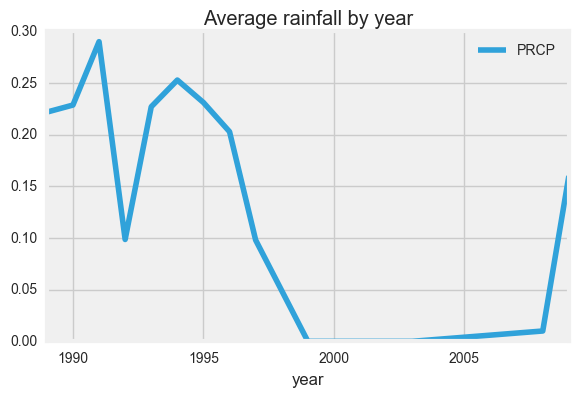

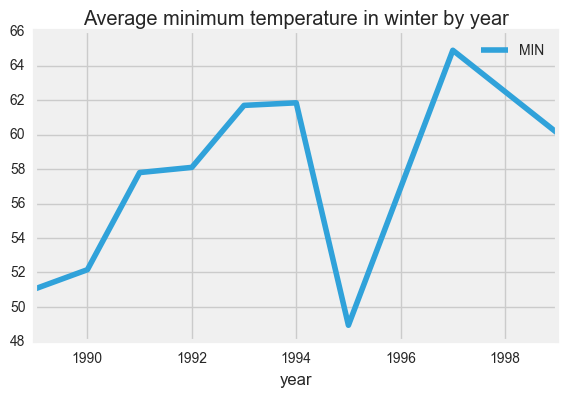

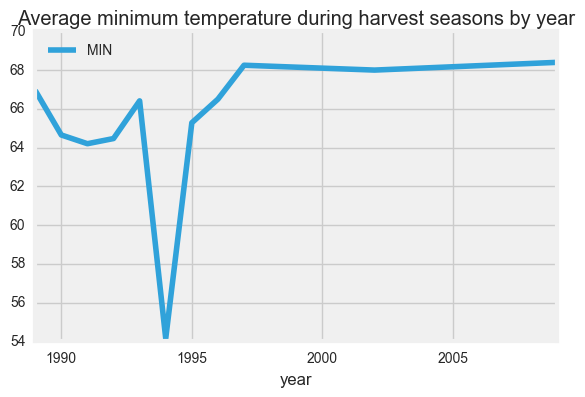

In [10]:
brazil_weather_data[["year", "PRCP"]].groupby(by = "year").mean().plot()
plt.title("Average rainfall by year")
plt.show()

brazil_weather_data[brazil_weather_data["season"] == "winter"][["year", "MIN"]].groupby(by = "year").mean().plot()
plt.title("Average minimum temperature in winter by year")
plt.show()

brazil_weather_data[(brazil_weather_data["season"] == "summer") | (brazil_weather_data["season"] == "spring")][["year", "MIN"]].groupby(by = "year").mean().plot()
plt.title("Average minimum temperature during harvest seasons by year")
plt.show()

In [26]:
raw_ICO_index_data = pd.read_csv("../datasets/capstone/us_monthlycommoditypriceaverages_03927558512071.csv", encoding = "ISO-8859-1", header = 1)

In [27]:
ICO_index_data = raw_ICO_index_data.copy()
ICO_index_data = ICO_index_data.drop(labels = 0).T
ICO_index_data["time"] = pd.to_datetime(ICO_index_data.index.values)
ICO_index_data.columns = ICO_index_data.loc["PERIOD", :]
ICO_index_data = ICO_index_data.drop(labels = ["PERIOD"])
ICO_index_data = ICO_index_data.apply(pd.to_numeric, errors = 'coerce')

ValueError: Unknown string format

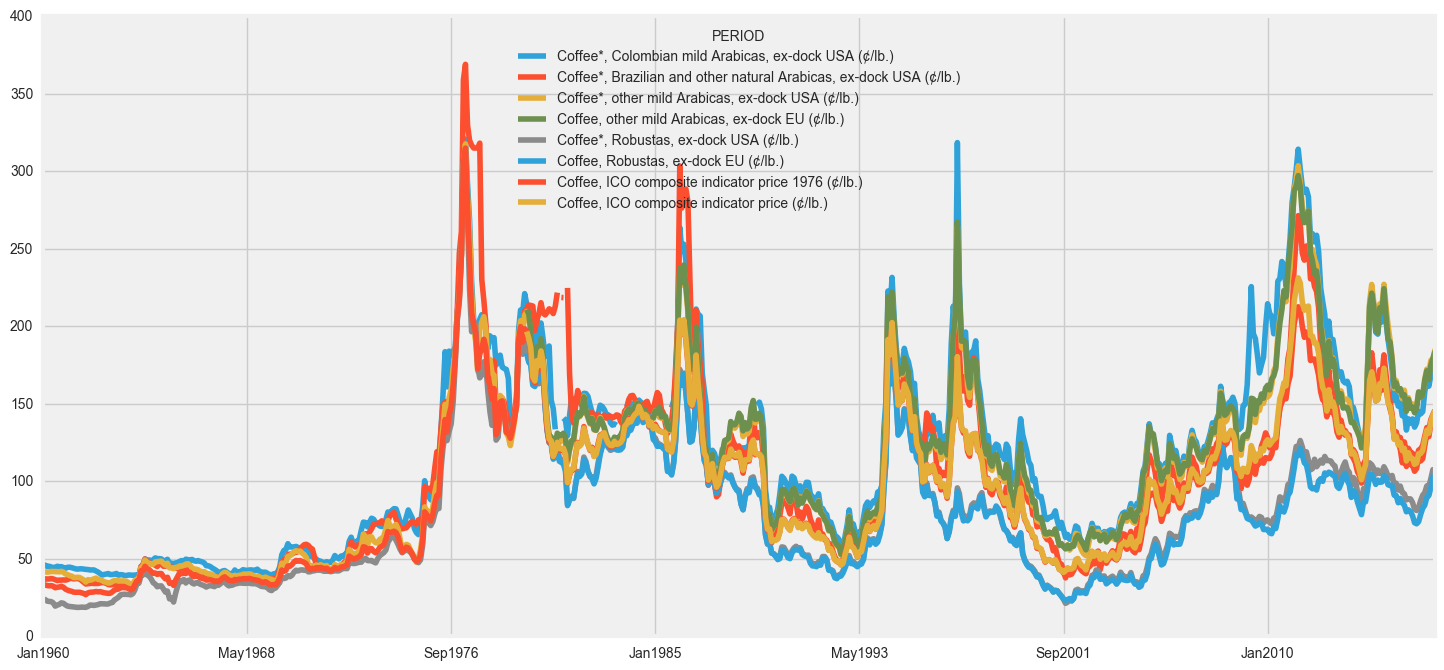

In [14]:
ICO_index_data.plot(figsize=(16,8))
sns.plt.show()

In [43]:
pd.to_datetime(ICO_index_data.index.values[1:], format = "%b%Y")
ICO_index_data.rename(columns = ICO_index_data.loc["PERIOD", :])
ICO_index_data.drop("PERIOD", inplace = True)

PERIOD,"Coffee*, Colombian mild Arabicas, ex-dock USA (¢/lb.)","Coffee*, Brazilian and other natural Arabicas, ex-dock USA (¢/lb.)","Coffee*, other mild Arabicas, ex-dock USA (¢/lb.)","Coffee, other mild Arabicas, ex-dock EU (¢/lb.)","Coffee*, Robustas, ex-dock USA (¢/lb.)","Coffee, Robustas, ex-dock EU (¢/lb.)","Coffee, ICO composite indicator price 1976 (¢/lb.)","Coffee, ICO composite indicator price (¢/lb.)"
Jan1960,45.68,36.33,41.29,..,23.41,..,32.72,..
Feb1960,45.95,37.05,41.55,..,23.73,..,33.19,..
Mar1960,45.1,36.95,41.41,..,22.72,..,32.75,..
Apr1960,45.2,36.95,41.5,..,22.48,..,32.54,..
May1960,44.73,37.25,41.82,..,22.4,..,32.69,..
Jun1960,44.38,37,41.79,..,21.58,..,32.34,..
Jul1960,44.55,36.48,41.75,..,19.45,..,31.31,..
Aug1960,45.15,35.98,41.68,..,20.1,..,31.63,..
Sep1960,44.85,36.23,41.56,..,20.6,..,31.8,..
Oct1960,44.9,36.25,41.9,..,21.56,..,32.25,..
